# Generación de Predicciones con Regresión Lineal
Este notebook implementa una regresión lineal para predecir valores en un conjunto de datos simulados.

## 1. Importación de Bibliotecas

In [51]:
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

import openpyxl
import warnings
import re

## 2. Extracción y limpieza de datos

<span style="color:white; font-weight:bold">2.1 Extracción</span>

Los datos se generaron directamente de la base de datos MSSQL con las ventas reales de la empresa HBS-Delli, del 2020 a la fecha (diciembre 2024).

In [34]:
df = pd.read_excel("../data/Ventas_CapstoneProject_Agrupado.xlsx", sheet_name="Ventas")

In [49]:
df.info()    #172725

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110094 entries, 0 to 110093
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   fecha_emision    110094 non-null  datetime64[ns]
 1   empresa          110094 non-null  object        
 2   numero_cliente   110094 non-null  int64         
 3   nombre_cliente   110094 non-null  object        
 4   rama_cliente     110094 non-null  object        
 5   tipo_cliente     110094 non-null  object        
 6   articulo         110094 non-null  object        
 7   desc_articulo    110094 non-null  object        
 8   cantidad         110094 non-null  float64       
 9   precio           110094 non-null  float64       
 10  subTotal         110094 non-null  float64       
 11  iva              110094 non-null  float64       
 12  ieps             110094 non-null  float64       
 13  importe_total    110094 non-null  float64       
 14  costo_unitario   110

<span style="color:white; font-weight:bold">2.2 Limpieza</span>

La mayor parte de la limpieza de datos se realizaron directamente en la base de datos MSSQL, sin embargo se utilizo pandas para realizar una validación de la información y preparar el dataset para su analisis.

In [36]:
#validar nulos
if df.isnull().sum().sum() > 0:
    df = df.dropna()
    print("Se eliminaron las filas con valores nulos.")
else:
    print("No se encontraron valores nulos en el DataFrame.")

# Preparando información de la venta
df = df.rename(columns={'FechaEmision': 'fecha_emision'
                        , "Empresa": "empresa"
                        })

# Preparando informacion del artículo
df['numero_articulo'] = pd.to_numeric(
                                    df['Articulo'].str.extract(r'(\d+)')[0]     # Extraer solo números
                                    ,errors='coerce'                            # Convertir valores inválidos a NaN
                                    ).fillna(0).astype(int)                     # Reemplazar NaN por 0 y convertir a entero
df = df.rename(columns={"Articulo": "articulo"
                        ,'Desc_Articulo': 'desc_articulo'
                        , 'FechaEmision': 'fecha_emision'
                        , "Empresa": "empresa"
                        , "Mov": "mov"
                        , "MovId": "movId"
                        , "Lote": "lote"
                        })

# Preparando información del cliente
df = df.rename(columns={'Numero_Cliente': 'numero_cliente'
                        , 'Nombre_Cliente': 'nombre_cliente'
                        , "Rama": "rama_cliente"
                        , "Tipo" : "tipo_cliente"
                        , "Linea": "linea"
                        , "Modulo": "modulo"
                        })
df['numero_cliente'] = df['numero_cliente'].fillna('Desconocido')

# Preparando información de las cantidad
df = df.rename(columns={"Cantidad": "cantidad"
                        , "Lote": "lote"
                        , "UM": "unidad_medida"
                        , "Precio": "precio"
                        , "SubTotal": "subTotal"
                        , "DescuentoLineal": "descuento_lineal"
                        , "IVA": "iva"
                        , "IEPS": "ieps"
                        , "ImporteTotal": "importe_total"
                        , "Costo_Unitario": "costo_unitario"
                        , "Costo_Total": "costo_total"
                          })

# Eliminando información no requerida para el analisis
df = df.drop(columns=["IEPS_Cuota", "Numero_Orden"])



No se encontraron valores nulos en el DataFrame.


In [37]:
# Calcular Q1 (percentil 25) y Q3 (percentil 75)
Q1 = df['cantidad'].quantile(0.25)
Q3 = df['cantidad'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para valores no atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame eliminando valores atípicos
df_sin_picos = df[(df['cantidad'] >= lower_bound) & (df['cantidad'] <= upper_bound)]

# Mostrar resultados
print(f"Filas antes de eliminar atípicos: {len(df)}")
print(f"Filas después de eliminar atípicos: {len(df_sin_picos)}")

#Comentar si se quieren utilizar datos atipicos
# df = df_sin_picos

Filas antes de eliminar atípicos: 110094
Filas después de eliminar atípicos: 98044


In [38]:
# Agrupar por fecha y sumar 'ImporteTotal' (como ejemplo de serie temporal)
serie_temporal = df.groupby('fecha_emision')['cantidad'].sum().reset_index()

# Aplicar la prueba ADF a la columna 'ImporteTotal'
resultado_adf = adfuller(serie_temporal['cantidad'])

# Mostrar los resultados
print("Resultados de la Prueba de Dickey-Fuller:")
print(f"Estadístico de prueba: {resultado_adf[0]:.4f}")
print(f"P-valor: {resultado_adf[1]:.4f}")
print("Valores críticos:")
for key, value in resultado_adf[4].items():
    print(f"  {key}: {value:.4f}")

Resultados de la Prueba de Dickey-Fuller:
Estadístico de prueba: -1.3185
P-valor: 0.6207
Valores críticos:
  1%: -3.5529
  5%: -2.9147
  10%: -2.5951


**Revisión de la información**


In [ ]:
df.info()

## 3. División del Conjunto de Datos

**3.1: Identificar posibles regresore**

Para determinar qué regresores adicionales serían útiles en tu modelo Prophet, debemos analizar la correlación entre la columna objetivo (Cantidad) y las demás columnas del DataFrame. Esto nos permitirá identificar qué variables explicativas tienen una relación significativa con la variable que quieres predecir

<h4>Pasos:</h4>
<ol>
    <li>Seleccionar columnas númericas</li>
    <li>calcular la correlación con la variable objetivo "Cantidad"</li>
    <li>Identificar las columnas con mas correlación</li>
</ol>

Recomendación: seleccionar las variables con mas alta correlación (+1 ó -1)

In [25]:
# Seleccionar solo las columnas numéricas del DataFrame
numerical_cols = df.select_dtypes(include=['number']).columns

# Calcular la correlación de las columnas numéricas con 'Cantidad'
correlations = df[numerical_cols].corr()['cantidad'].drop('cantidad').sort_values(ascending=False)

# Mostrar las columnas más correlacionadas con 'Cantidad'
print("Correlaciones con la columna 'Cantidad':")
print(correlations)


Correlaciones con la columna 'Cantidad':
costo_total        0.981190
subTotal           0.960979
Importe_Total      0.923155
ieps               0.707190
iva                0.707190
precio             0.195870
costo_unitario     0.131093
numero_cliente    -0.065535
numero_articulo         NaN
Name: cantidad, dtype: float64


In [44]:
df["fecha_emision"] =  pd.to_datetime(df["fecha_emision"], errors="coerce" , format="%d/%m/%Y")     #Convirtiendo fecha_emision en conjunto de fechas
df = df.dropna(subset=["fecha_emision"])                                                            #Eliminando posibles fechas invalidas

# Filtrar datos de entrenamiento, validación y futuros
train       = df[df['fecha_emision'] <= '2023-12-01']
train       = train[train['fecha_emision'] >= '2021-05-01']
valid       = df[df['fecha_emision'] >= '2024-01-01']
valid       = valid[valid['fecha_emision'] <= '2024-11-01']

train_full  = df

# Preparar los datos para Prophet
#train_data = train.rename(columns={"fecha_emision": "ds", "cantidad": "y"})[["ds", "y", "numero_cliente", "numero_articulo"]]
#valid_data = valid.rename(columns={"fecha_emision": "ds", "cantidad": "y"})[["ds", "y", "numero_cliente", "numero_articulo"]]

train_data = train.rename(columns={"fecha_emision": "ds", "cantidad": "y"})[["ds", "y"]]
valid_data = valid.rename(columns={"fecha_emision": "ds", "cantidad": "y"})[["ds", "y"]]



In [27]:
valid_data

,ds,y
290,2023-01-01,36
291,2023-01-01,1
292,2023-01-01,2
293,2023-01-01,1
294,2023-01-01,180
...,...,...
1465,2023-12-01,106
1466,2023-12-01,240
1467,2023-12-01,288
1468,2023-12-01,360


## 4. Entrenamiento del Modelo Prophet

In [45]:
# Validando
# valid_articulo  = valid[valid['articulo'] == "DL00003413"] #.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})
# valid_articulo  = valid_articulo.groupby("fecha_emision")[["cantidad", "costo_total"]].sum().reset_index()
# valid_articulo  = valid_articulo.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})
# valid_articulo

valid[valid['articulo'] == "DL00000068"].groupby("fecha_emision").agg({
    "cantidad": "sum"
    ,"costo_total": "sum"
}).reset_index

<bound method DataFrame.reset_index of                cantidad  costo_total
fecha_emision                       
2024-01-01       2984.0  538475.1240
2024-02-01       2981.0  524656.4668
2024-03-01       2981.0  545114.7471
2024-04-01       3315.0  593648.1155
2024-05-01       2974.0  527930.6341
2024-06-01       3087.0  559373.7299
2024-07-01       3424.0  644972.3291
2024-08-01       3272.0  594930.4230
2024-09-01       2406.0  455093.7649
2024-10-01       2901.0  538335.8172
2024-11-01       2821.0  525226.9382>

04:03:54 - cmdstanpy - INFO - Chain [1] start processing
04:03:54 - cmdstanpy - INFO - Chain [1] done processing


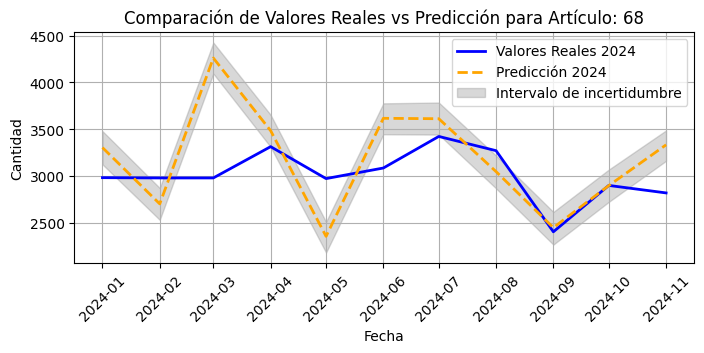

04:03:54 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 378.91
RMSE (Raíz del Error Cuadrático Medio): 509.99
R2 (Coeficiente de Determinación): -2.79


04:03:54 - cmdstanpy - INFO - Chain [1] done processing


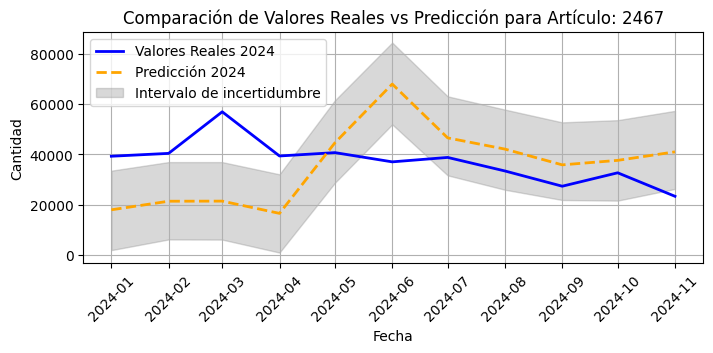

04:03:55 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 16459.97
RMSE (Raíz del Error Cuadrático Medio): 19338.12
R2 (Coeficiente de Determinación): -4.51


04:03:55 - cmdstanpy - INFO - Chain [1] done processing


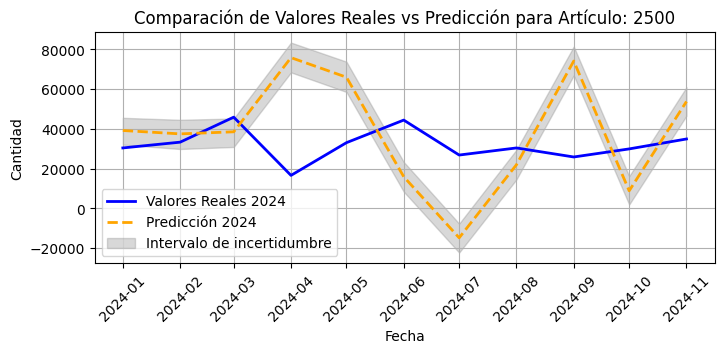

04:03:55 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 25368.19
RMSE (Raíz del Error Cuadrático Medio): 30857.12
R2 (Coeficiente de Determinación): -14.66


04:03:55 - cmdstanpy - INFO - Chain [1] done processing


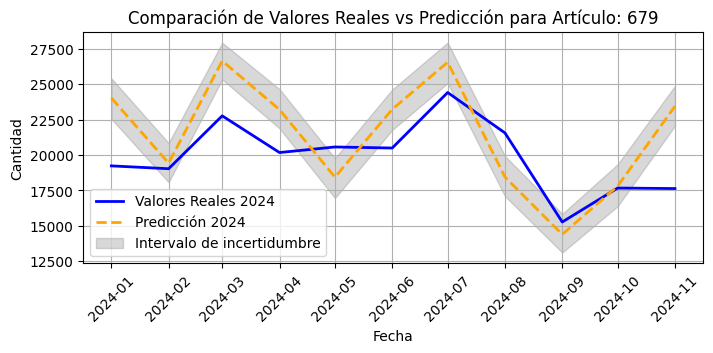

04:03:56 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 2641.14
RMSE (Raíz del Error Cuadrático Medio): 3137.64
R2 (Coeficiente de Determinación): -0.67


04:03:56 - cmdstanpy - INFO - Chain [1] done processing


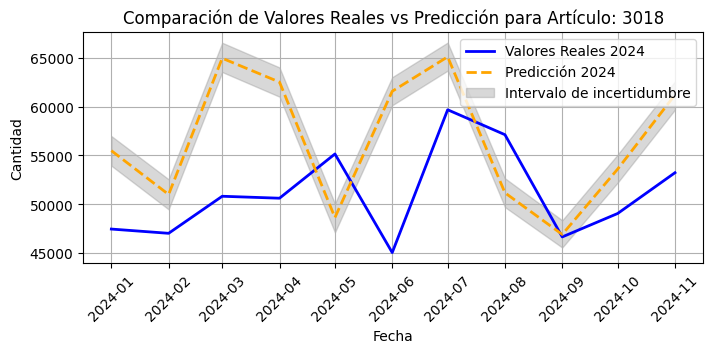

04:03:56 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 7753.55
RMSE (Raíz del Error Cuadrático Medio): 8982.50
R2 (Coeficiente de Determinación): -3.00


04:03:56 - cmdstanpy - INFO - Chain [1] done processing


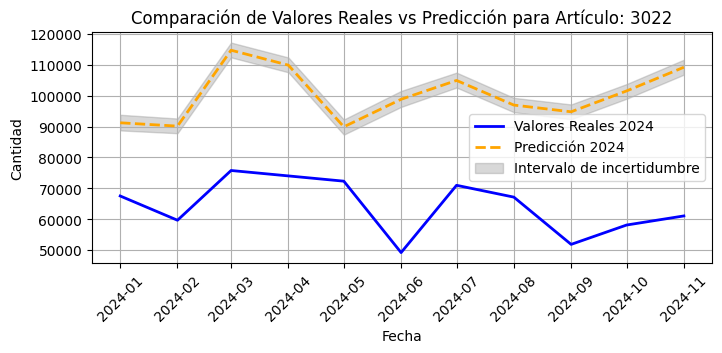

04:03:57 - cmdstanpy - INFO - Chain [1] start processing
04:03:57 - cmdstanpy - INFO - Chain [1] done processing


MAE (Error Absoluto Medio): 35827.21
RMSE (Raíz del Error Cuadrático Medio): 37081.49
R2 (Coeficiente de Determinación): -17.78


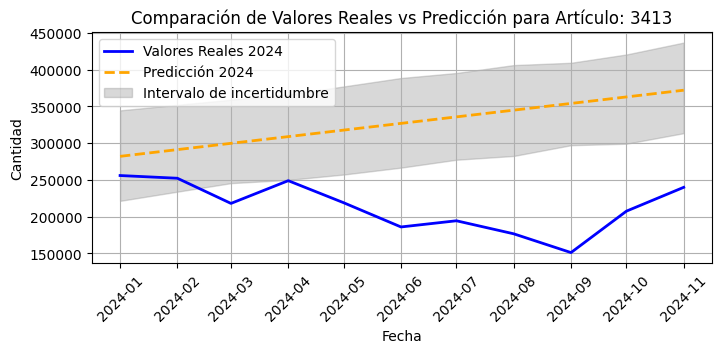

04:03:57 - cmdstanpy - INFO - Chain [1] start processing
04:03:57 - cmdstanpy - INFO - Chain [1] done processing


MAE (Error Absoluto Medio): 113226.20
RMSE (Raíz del Error Cuadrático Medio): 125362.23
R2 (Coeficiente de Determinación): -13.78


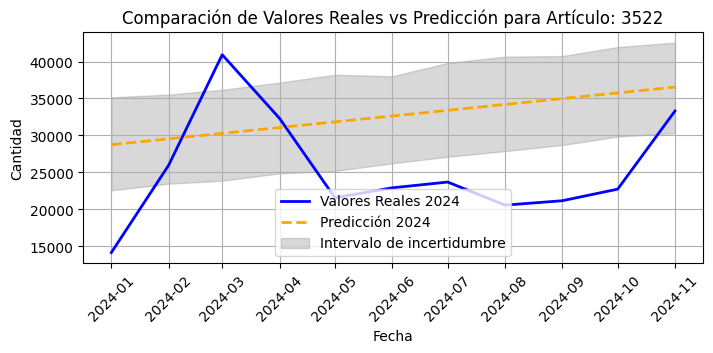

04:03:57 - cmdstanpy - INFO - Chain [1] start processing
04:03:57 - cmdstanpy - INFO - Chain [1] done processing


MAE (Error Absoluto Medio): 9406.34
RMSE (Raíz del Error Cuadrático Medio): 10408.43
R2 (Coeficiente de Determinación): -1.17


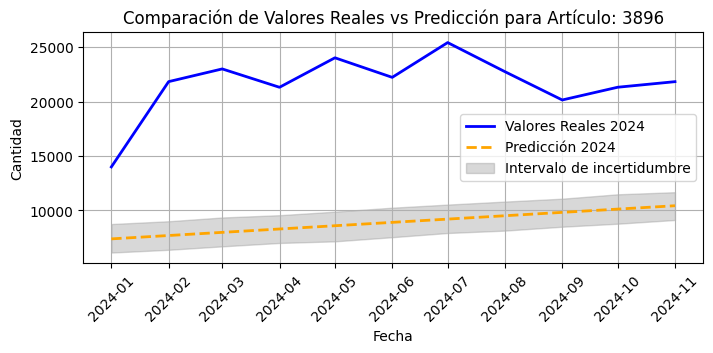

MAE (Error Absoluto Medio): 12705.28
RMSE (Raíz del Error Cuadrático Medio): 12969.29
R2 (Coeficiente de Determinación): -20.98


In [47]:
# Obtener la lista de artículos únicos
articulos_unicos = df['numero_articulo'].unique()

# Crear una gráfica por cada artículo
for articulo in articulos_unicos:
    # Filtrar los datos por artículo
    train_articulo  = train[train['numero_articulo'] == articulo] #.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})
    #train_articulo  = train_articulo.groupby("fecha_emision")[["cantidad", "costo_total"]].sum().reset_index()
    train_articulo  = train_articulo.groupby("fecha_emision")["cantidad"].sum().reset_index()
    train_articulo  = train_articulo.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})

    valid_articulo  = valid[valid['numero_articulo'] == articulo] #.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})
    valid_articulo  = valid_articulo.groupby("fecha_emision")["cantidad"].sum().reset_index()
    valid_articulo  = valid_articulo.rename(columns={'fecha_emision': 'ds', 'cantidad': 'y'})

    # Continuar solo si hay datos suficientes
    if len(train_articulo) == 0 or len(valid_articulo) == 0:
        continue

    # Inicializar y entrenar el modelo Prophet
    model           = Prophet()
    #model.add_regressor("costo_total")
    model.fit(train_articulo)

    
    # Crear horizonte de predicción con las fechas de validación
    future          = valid_articulo[['ds']].copy()
    forecast        = model.predict(future)


    #Prediccion para los siguientes 3 Meses
    future_3_meses  = model.make_future_dataframe(periods=3, freq="ME")

    # Filtrar solo las fechas de 2024
    valid_2024      = valid_articulo
    forecast_2024   = forecast

    # Graficar valores reales y predicciones
    plt.figure(figsize=(8, 3))
    plt.plot(valid_2024['ds'], valid_2024['y'], label='Valores Reales 2024', color='blue', linewidth=2)
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Predicción 2024', linestyle='--', color='orange', linewidth=2)
    plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_lower'], forecast_2024['yhat_upper'], 
                     color='gray', alpha=0.3, label='Intervalo de incertidumbre')
    plt.xticks(rotation=45)

    # Configuración de la gráfica
    plt.title(f"Comparación de Valores Reales vs Predicción para Artículo: {articulo}")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad")
    plt.legend()
    plt.grid()
    plt.show()

    # Calcular métricas de desempeño
    mae = mean_absolute_error(valid_2024['y'], forecast_2024['yhat'])
    rmse = np.sqrt(mean_squared_error(valid_2024['y'], forecast_2024['yhat']))
    r2 = r2_score(valid_2024['y'], forecast_2024['yhat'])

    print(f"MAE (Error Absoluto Medio): {mae:.2f}")
    print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
    print(f"R2 (Coeficiente de Determinación): {r2:.2f}")

    
    

In [26]:
train_data

,ds,y
433,2020-11-01,30.0
434,2020-11-01,24.0
435,2020-11-01,32.0
436,2020-11-01,18.0
437,2020-11-01,10.0
...,...,...
76535,2023-12-01,180.0
76539,2023-12-01,-1.0
76540,2023-12-01,1.0
76541,2023-12-01,2.0


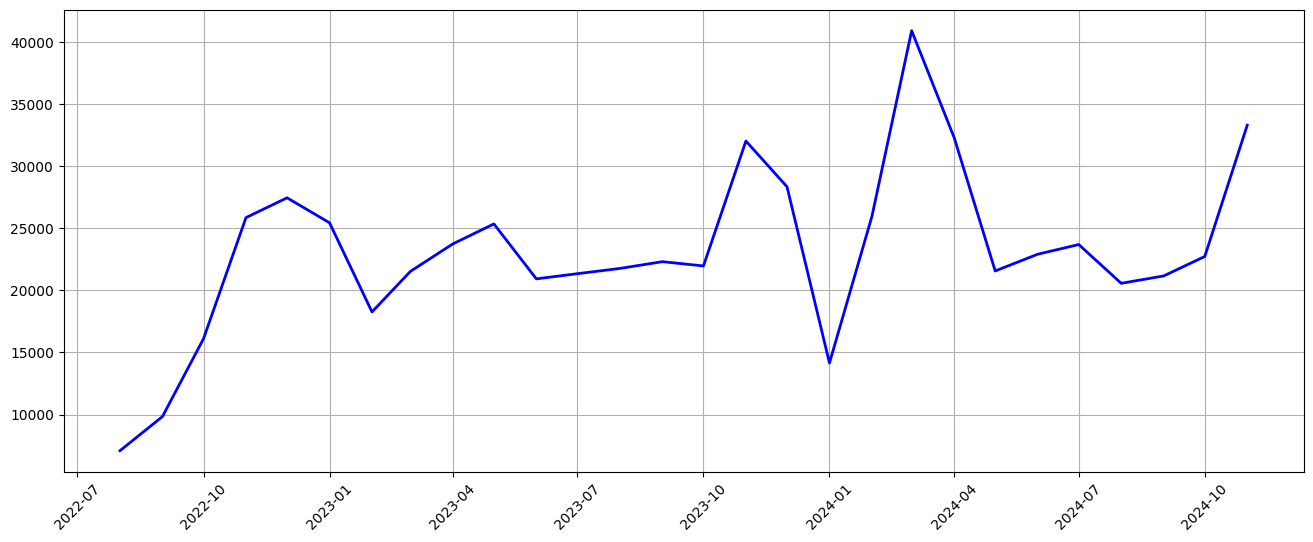

In [30]:
df_86 = train_full[train_full['numero_articulo'] == 3522].groupby("fecha_emision")["cantidad"].sum().reset_index()
plt.figure(figsize=(16, 6))
plt.plot(df_86["fecha_emision"], df_86['cantidad'], label='articulo 68', color='blue', linewidth=2)
plt.xticks(rotation=45)

plt.grid()
plt.show()

## 5. Evaluación del Modelo

In [ ]:
# Evaluar el error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(valid_data['y'], forecast['yhat'])
rmse = np.sqrt(mean_squared_error(valid_data['y'], forecast['yhat']))

print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")

## 7. Visualización de Resultados

In [ ]:
# Visualizamos las predicciones vs los datos reales
plt.scatter(X_test, y_test, color='blue', label='Datos Reales')
plt.plot(X_test, y_pred, color='red', label='Predicciones')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.title('Regresión Lineal: Datos vs Predicciones')
plt.legend()
plt.show()

17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing


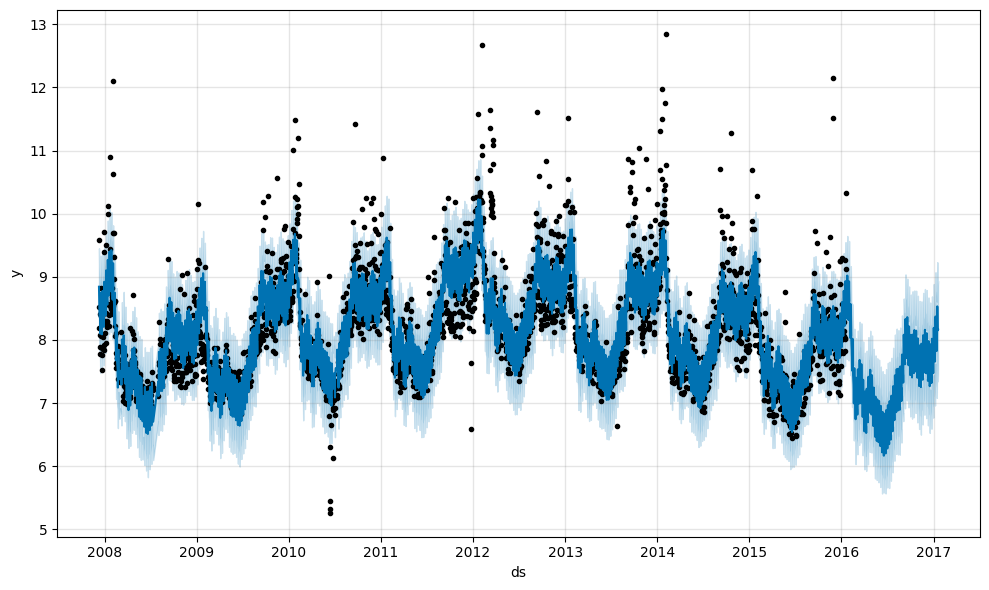

In [51]:
# Python
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
# fig2 = m.plot_components(forecast)

